In [1]:
from statsbombpy import sb

# Get a DataFrame of all available competitions
competitions = sb.competitions()

# Display the available competitions so you can choose
print("--- Available Competitions ---")
print(competitions[['competition_id', 'season_id', 'competition_name', 'season_name']])

/opt/anaconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


--- Available Competitions ---
    competition_id  season_id        competition_name season_name
0                9        281           1. Bundesliga   2023/2024
1                9         27           1. Bundesliga   2015/2016
2             1267        107  African Cup of Nations        2023
3               16          4        Champions League   2018/2019
4               16          1        Champions League   2017/2018
..             ...        ...                     ...         ...
69              55         43               UEFA Euro        2020
70              35         75      UEFA Europa League   1988/1989
71              53        106       UEFA Women's Euro        2022
72              72        107       Women's World Cup        2023
73              72         30       Women's World Cup        2019

[74 rows x 4 columns]


In [3]:
import pandas as pd
from statsbombpy import sb

# IDs for the Bundesliga 2023/2024 season
COMP_ID = 9
SEASON_ID = 281

# Get all the matches from your chosen season
matches = sb.matches(competition_id=COMP_ID, season_id=SEASON_ID)

# Get the list of all match IDs
match_ids = matches['match_id'].tolist()

print(f"Found {len(match_ids)} matches for Bundesliga 2023/2024. Fetching all event data now...")
print("This will take several minutes to run...")

# Use a list comprehension to get all events from all matches
all_events = [sb.events(match_id=m) for m in match_ids]

# Concatenate all the separate match DataFrames into one large DataFrame
df_all_events = pd.concat(all_events)

print(f"✅ SUCCESS! Loaded data for the full season.")
print(f"Total events in the dataset: {len(df_all_events)}")
print("\n--- Sample of the Full Event Dataset ---")
print(df_all_events[['team', 'player', 'type', 'location']].head())

/opt/anaconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


Found 34 matches for Bundesliga 2023/2024. Fetching all event data now...
This will take several minutes to run...


/opt/anaconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/st

✅ SUCCESS! Loaded data for the full season.
Total events in the dataset: 137765

--- Sample of the Full Event Dataset ---
               team player         type location
0  Bayer Leverkusen    NaN  Starting XI      NaN
1     Werder Bremen    NaN  Starting XI      NaN
2  Bayer Leverkusen    NaN   Half Start      NaN
3     Werder Bremen    NaN   Half Start      NaN
4  Bayer Leverkusen    NaN   Half Start      NaN


In [5]:
import pandas as pd
import numpy as np

# --- Step 1: Filter for relevant actions ---
# We are interested in actions where a player is in control of the ball.
df_actions = df_all_events[df_all_events['type'].isin(['Pass', 'Dribble', 'Shot'])].copy()


# --- Step 2: Extract Start Coordinates ---
# The 'location' column is a list [x, y], so we split it into two new columns.
# We use .apply() and a lambda function for this.
df_actions['x_start'] = df_actions['location'].apply(lambda loc: loc[0])
df_actions['y_start'] = df_actions['location'].apply(lambda loc: loc[1])


# --- Step 3: Extract End Coordinates for Passes ---
# The 'pass_end_location' column only exists for passes.
# We check if the value is a list before trying to split it. If not, we put NaN (np.nan).
df_actions['x_end'] = df_actions['pass_end_location'].apply(lambda loc: loc[0] if isinstance(loc, list) else np.nan)
df_actions['y_end'] = df_actions['pass_end_location'].apply(lambda loc: loc[1] if isinstance(loc, list) else np.nan)


print("✅ SUCCESS! Actions DataFrame created with start and end coordinates.")
print(f"Total actions to analyze: {len(df_actions)}")

# Display a sample of the new columns for Pass events to verify
print("\n--- Sample of Processed Pass Data ---")
print(df_actions[df_actions['type'] == 'Pass'][['team', 'player', 'type', 'x_start', 'y_start', 'x_end', 'y_end']].head())

✅ SUCCESS! Actions DataFrame created with start and end coordinates.
Total actions to analyze: 41043

--- Sample of Processed Pass Data ---
             team           player  type  x_start  y_start  x_end  y_end
6   Werder Bremen   Nick Woltemade  Pass     61.0     40.1   59.0   40.9
7   Werder Bremen   Marvin Ducksch  Pass     59.0     40.6   35.1   43.2
8   Werder Bremen   Christian Groß  Pass     35.1     43.7   33.2   63.8
9   Werder Bremen  Julián Malatini  Pass     32.7     65.3   44.5   77.8
10  Werder Bremen  Mitchell Weiser  Pass     44.5     77.5   62.2   65.8


In [7]:
# Define the number of zones for the grid
X_BINS = 16
Y_BINS = 12
PITCH_LENGTH = 120
PITCH_WIDTH = 80

# Assign a start zone to every action
df_actions['x_start_bin'] = pd.cut(df_actions['x_start'], bins=X_BINS, labels=False)
df_actions['y_start_bin'] = pd.cut(df_actions['y_start'], bins=Y_BINS, labels=False)
df_actions['start_zone'] = df_actions['x_start_bin'] * Y_BINS + df_actions['y_start_bin']

# Assign an end zone for passes
df_actions['x_end_bin'] = pd.cut(df_actions['x_end'], bins=X_BINS, labels=False)
df_actions['y_end_bin'] = pd.cut(df_actions['y_end'], bins=Y_BINS, labels=False)
df_actions['end_zone'] = df_actions['x_end_bin'] * Y_BINS + df_actions['y_end_bin']

print("✅ Zones assigned to every action.")
print(df_actions[['type', 'start_zone', 'end_zone']].head())

✅ Zones assigned to every action.
    type  start_zone  end_zone
6   Pass         102      90.0
7   Pass          90      54.0
8   Pass          54      57.0
9   Pass          57      71.0
10  Pass          71     105.0


In [9]:
# --- Calculate Shot Probability for each zone ---
# Group by zone and count the number of shots vs. total actions
shot_probs = df_actions.groupby('start_zone')['type'].apply(lambda x: (x == 'Shot').sum() / len(x))

# --- Calculate Move Probability (Transition Matrix) ---
# First, filter for successful moves (we'll consider completed passes for now)
df_moves = df_actions[df_actions['type'] == 'Pass'].copy()
# Drop any moves that don't have a valid end zone
df_moves.dropna(subset=['end_zone'], inplace=True)
df_moves['end_zone'] = df_moves['end_zone'].astype(int)

# Create the transition matrix using crosstab
# This calculates the probability of moving from a start_zone to an end_zone
transition_matrix = pd.crosstab(df_moves['start_zone'], df_moves['end_zone'], normalize='index')


print("\n✅ Probabilities calculated!")
print("\n--- Sample of Shot Probabilities (Zone: Probability) ---")
print(shot_probs.head())
print("\n--- Sample of Move Transition Matrix ---")
print(transition_matrix.head())


✅ Probabilities calculated!

--- Sample of Shot Probabilities (Zone: Probability) ---
start_zone
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: type, dtype: float64

--- Sample of Move Transition Matrix ---
end_zone         0         1         2         3         4         5    \
start_zone                                                               
0           0.121951  0.073171  0.097561  0.000000  0.024390  0.000000   
1           0.075472  0.094340  0.018868  0.037736  0.037736  0.000000   
2           0.078947  0.000000  0.000000  0.026316  0.052632  0.000000   
3           0.025000  0.012500  0.012500  0.025000  0.025000  0.025000   
4           0.000000  0.013889  0.000000  0.013889  0.000000  0.222222   

end_zone         6         7    8    9    ...  182  183  184  185  186  187  \
start_zone                                ...                                 
0           0.000000  0.000000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
1           0.000000  0.000000  

In [11]:
# Filter for only shot events
df_shots = df_actions[df_actions['type'] == 'Shot'].copy()

# Group by zone and get the average xG
# We'll fill zones with no shots with 0.
shot_xG = df_shots.groupby('start_zone')['shot_statsbomb_xg'].mean().fillna(0)

In [13]:
# Initialize our xT grid with zeros
num_zones = X_BINS * Y_BINS
xt_grid = np.zeros(num_zones)

# The probability of not shooting is 1 - shot_probability
move_probs = 1 - shot_probs.reindex(range(num_zones), fill_value=0)

# The expected threat from shooting in a zone
shot_threat = shot_probs.reindex(range(num_zones), fill_value=0) * shot_xG.reindex(range(num_zones), fill_value=0)

# Iteratively calculate the xT values
for i in range(10):
    # The expected threat from moving is the probability of moving to each zone multiplied by the current xT value of that zone
    # We use a dot product of our transition matrix and the current xT grid
    move_threat = np.dot(transition_matrix.reindex(range(num_zones), fill_value=0).reindex(range(num_zones), axis=1, fill_value=0), xt_grid)
    
    # The new xT value is the threat from shooting plus the threat from moving (weighted by the probability of each)
    xt_grid = shot_threat + (move_probs * move_threat)

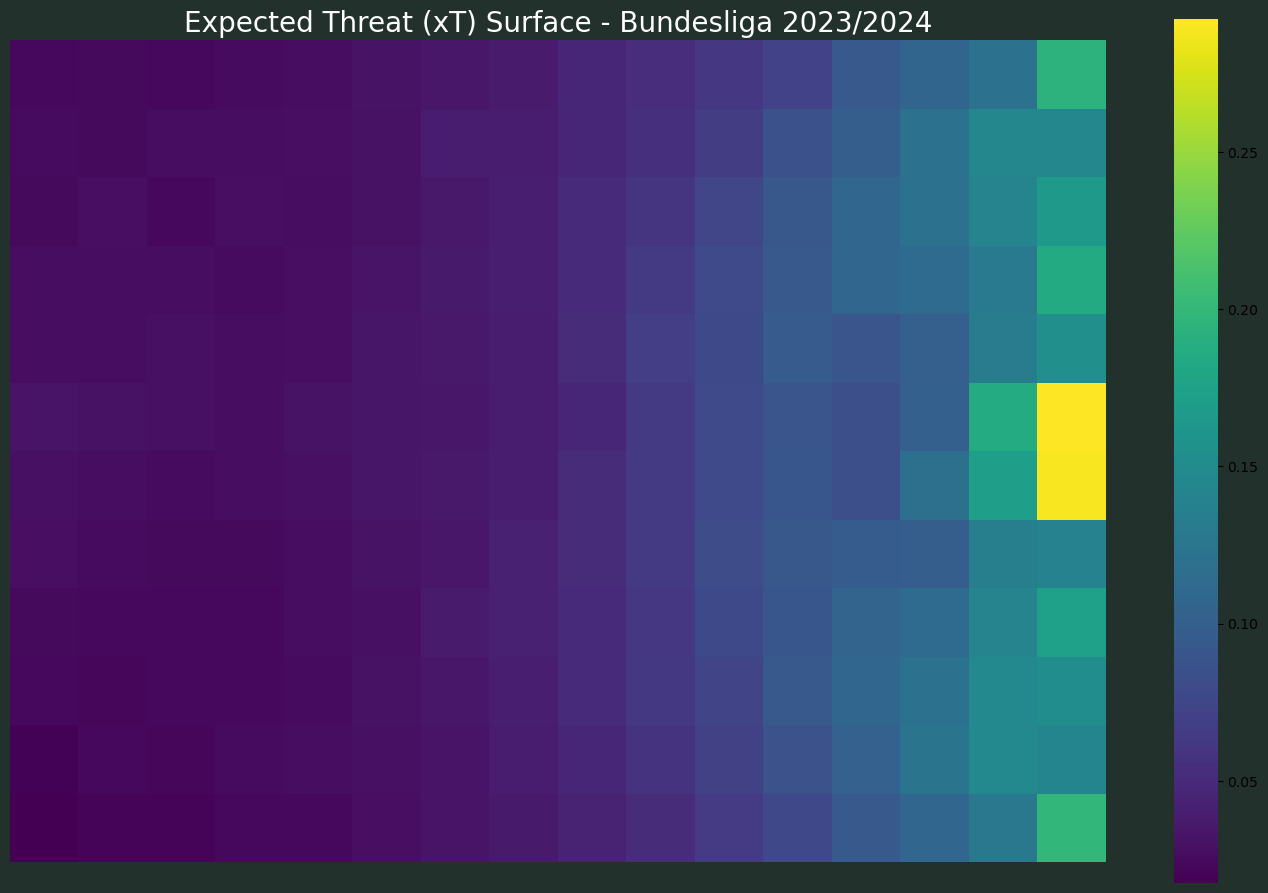

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import Pitch
import numpy as np

# --- THIS IS THE FIX ---
# Convert the xt_grid from a pandas Series to a NumPy array before reshaping
xt_grid_2d = xt_grid.to_numpy().reshape(X_BINS, Y_BINS)


# --- Create the Plot ---
# Set up the pitch using mplsoccer
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(14, 9), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#22312b')

# Use seaborn to plot the heatmap of our xT grid.
# We flip the grid vertically for the correct pitch orientation (goal at the top).
sns.heatmap(np.flipud(xt_grid_2d.T), cmap='viridis', annot=False, ax=ax)

ax.set_title('Expected Threat (xT) Surface - Bundesliga 2023/2024', color='white', size=20)
plt.show()

In [19]:
# Calculate the xT Added for every pass
# We only look at passes that have a valid start and end zone
df_passes = df_actions[df_actions['type'] == 'Pass'].dropna(subset=['start_zone', 'end_zone'])

# Look up the xT value for the start and end zone of each pass
xt_start = xt_grid[df_passes['start_zone'].astype(int)].values
xt_end = xt_grid[df_passes['end_zone'].astype(int)].values

# xT Added is the difference between the end and start threat
df_passes['xt_added'] = xt_end - xt_start

# --- Generate the Player Leaderboard ---
# Group by player and sum their total xT Added over the season
player_xt = df_passes.groupby('player')['xt_added'].sum().sort_values(ascending=False)

print("✅ SUCCESS! Player rankings have been calculated.")
print("\n--- Top 15 Most Threatening Players (by xT Added) ---")
print(player_xt.head(15))

✅ SUCCESS! Player rankings have been calculated.

--- Top 15 Most Threatening Players (by xT Added) ---
player
Granit Xhaka                   20.536774
Edmond Fayçal Tapsoba          18.002298
Jonathan Tah                   15.342431
Alejandro Grimaldo García      11.852804
Odilon Kossonou                 9.956863
Robert Andrich                  9.074251
Piero Martín Hincapié Reyna     8.640983
Florian Wirtz                   8.146576
Exequiel Alejandro Palacios     7.837350
Lukáš Hrádecký                  5.953892
Josip Stanišić                  5.569039
Jonas Hofmann                   3.910103
Manuel Riemann                  3.480115
Jeremie Frimpong                2.199552
Eric Dier                       1.818595
Name: xt_added, dtype: float64
